In [1]:
'''Main Code'''

#Import libraries and scripts

import torch
import torch.nn as nn
import io

import cv2

from torch.nn import init
from torch.autograd import Variable
import argparse
import torch.optim as optim
import math
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from math import log10
from torchvision.utils import save_image as imwrite

from model import ConvNetSep
from torchvision import transforms
import os

import data
from data import triplet_train, triplet_test

import model
import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm as tqdm_notebook
import time

In [2]:
#Check if gpu is available
torch.cuda.is_available()

True

# Experimental setup and argument parsing

In [3]:
#Using easydict instead of argparser because I am using notebook

from easydict import EasyDict as edict

args = edict()

# Training data
args.data_dir = '/home/trojan/Desktop/Image restoration/Homeworks/HW3/dataset/Dataet_VFI_HW3/Vimeo90K_HW3'  # training data 
args.save_dir = '/home/trojan/Desktop/Image restoration/Homeworks/HW3/result'   # results directory

# Model
args.exp_name = 'Net_SepConv'   # model to be selected
args.finetuning = False   # to finetune the training
args.load = None #'NetFinal'

#Validation data
args.val_data = True
args.val_batch_size = 1   # batch size for validation data
#args.n_threads = 8   # threads number for loading data'''

# Testing data
args.test_dir = '/home/trojan/Desktop/Image restoration/Homeworks/HW3/dataset/Dataet_VFI_HW3/ucf101_HW3'   # test dataset directory
args.save = True

# Training and Optimization
args.patch_size = 128
args.batch_size = 8
args.kernel_size = 25
args.lr = 1e-4   # learning rate for the optimizer
args.epochs = 200   # number of training epochs
#args.lr_step_size = 600   # decay learning rate after N epochs
#args.lr_gamma = 0.1   # learning rate decay factor
args.lr_decay = 100   #number of epochs to drop lr
args.decay_type = 'step' #lr decay type
args.loss_type = 'L1'   #Loss type

args.period = 5
args.gpu = True   # gpu index

In [4]:
#Basic Settings
if args.gpu == 0:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif args.gpu == 1:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
#Check cuda device
device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'
print (device)

cuda


# Define helper function

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

def to_variable(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def set_loss(args):
    loss_type = args.loss_type
    if loss_type == 'MSE':
        lossfunction = nn.MSELoss()
    elif loss_type == 'L1':
        lossfunction = nn.L1Loss()
    return lossfunction

def set_lr(args, epoch, optimizer):
    lr_decay = args.lr_decay
    decay_type = args.decay_type
    if decay_type == 'step':
        epoch_iter = (epoch + 1) // lr_decay
        lr = args.lr / 2 ** epoch_iter
    elif decay_type == 'exp':
        k = math.log(2) / lr_decay
        lr = args.lr * math.exp(-k * epoch)
    elif decay_type == 'inv':
        k = 1 / lr_decay
        lr = args.lr / (1 + k * epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def inc_epoch(self):
    self.epoch += 1

In [7]:
def test(model, Dataset, save_dir=args.save_dir, output_name='output.png'):
        test_dir = args.test_dir
        patch_size = args.patch_size
         
        avg_psnr = 0    
        test_loader = DataLoader(dataset=Dataset, batch_size=1, shuffle=False, num_workers=0)

        total_batches = 0 
        for batch_index, (Frame1, Frame2, Frame3) in enumerate(test_loader):
            Frame1 = to_variable(Frame1)
            Frame2 = to_variable(Frame2)
            Frame3 = to_variable(Frame3)
            frame_out, ver1, hor1, ver2, hor2 = model(Frame1, Frame3)
            gt = Frame2
            psnr = -10 * log10(torch.mean((gt - frame_out) * (gt - frame_out)).item())
            avg_psnr += psnr
            imwrite(frame_out, save_dir + '/' + '{}'.format(batch_index) + output_name, range=(0, 1))
            
            #ver1 = ver1.cpu().detach().numpy()
            #print(ver1.shape)
            #ver1 = np.transpose(ver1, (2, 3, 1, 0))
            #print(ver1.shape)
            #ver1 = cv2.cvtColor(ver1, cv2.COLOR_BGR2RGB)
            
            hor1 = hor1.cpu().detach().numpy()
            print(hor1.shape)
            hor1 = np.transpose(hor1, (2, 3, 1, 0))
            print(hor1.shape)
            hor1 = cv2.cvtColor(hor1, cv2.COLOR_BGR2RGB)
            
            #ver1 = ver1.clip(0, 255)
            #cv2.imwrite(save_dir + '/kernels/' + '{}.png'.format(batch_index), ver1)
            cv2.imwrite(save_dir + '/kernels/' + '{}.png'.format(batch_index), hor1)
            #imwrite(hor1, save_dir + '/kernels/' + '{}'.format(batch_index) + output_name, range=(0, 1))
            #imwrite(ver2, save_dir + '/kernels/' + '{}'.format(batch_index) + output_name, range=(0, 1))
            #imwrite(hor2, save_dir + '/kernels/' + '{}'.format(batch_index) + output_name, range=(0, 1))
            msg = "Batch: {}\t PSNR: {:<20.4f}\n".format(batch_index, psnr)
            total_batches += 1
            #print(msg, end='')
            #logfile.write(msg)
            
        avg_psnr /= total_batches
        return avg_psnr


# Training

In [8]:
def train(args):
    
    train_dir = args.data_dir
    save_dir = args.save_dir
    test_dir = args.test_dir
    batch_size = args.batch_size
    total_epochs = args.epochs
    patch_size = args.patch_size
    
    loss_function = set_loss(args)
    loss_function.cuda()
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    ckptDir = save_dir + '/chekpoint'
    resultDir = save_dir 
    
    if not os.path.exists(ckptDir):
        os.makedirs(ckptDir)
        
    dataset = triplet_train(train_dir, resize=(patch_size, patch_size))
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    test_dataset = triplet_test(test_dir, resize=None)
    test_resultDir = save_dir + '/test_result'
    
    test_output_dir = test_resultDir
    
    if not os.path.exists(test_resultDir):
        os.makedirs(test_resultDir)
    
    log_dir = save_dir + '/logging'
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        
    if os.path.exists(log_dir + '/log.txt'):
        logFile = open(log_dir + '/log.txt', 'a')
    else:
        logFile = open(log_dir + '/log.txt', 'w')
    
    logFile.write('Batch size: ' + str(batch_size) + '\n')
    
    if args.load is not None:
        checkpoint = torch.load(args.load)
        kernel_size = checkpoint['kernel_size']
        model = ConvNetSep(kernel_size=kernel_size)
        state_dict = checkpoint['state_dict']
        model.load_state_dict(state_dict)
        model.epoch = checkpoint['epoch']
    else:
        kernel_size = args.kernel_size
        model = ConvNetSep(kernel_size=kernel_size)

    logFile.write('Kernel size: ' + str(kernel_size) + '\n')
    num_params = count_parameters(model)
    logFile.write('Parameters: ' + str(num_params) + '\n')
    
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    start_epoch = 0
    epoch_time = 0
    total_time = 0
    max_step = train_loader.__len__()
    
    #model.eval()
    #test(model, test_dataset, start_epoch, test_output_dir, logfile, output_name = 'output.png')
    
    
    
    for epoch in range(start_epoch, total_epochs):
        start = time.time()
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
        learning_rate = set_lr(args, epoch, optimizer)
        print("Epoch {}/{}".format(epoch + 1, total_epochs))
        
        model.train()
        for batch_index, (Frame1, Frame2, Frame3) in enumerate(train_loader):
            Frame1 = to_variable(Frame1)
            Frame2 = to_variable(Frame2)
            Frame3 = to_variable(Frame3)
            output = model(Frame1, Frame3)
            loss = loss_function(output, Frame2)

            model.zero_grad()
            loss.backward()
            optimizer.step()  
            
        end = time.time()
        epoch_time = (end - start)
        total_time += epoch_time
        #model.inc_epoch()
        
        #if batch_index % 100 == 0:
        #if  (epoch + 1) % args.period == 0:
        log = "Epoch {}/{} \t Learning rate: {:.5f} \t Train Loss: {:.5f} \t Epoch Time: {:.4f} \t Total time: {:.4f}\n".format(epoch + 1, total_epochs,
                                                                                                                             learning_rate, loss, epoch_time, total_time)
        print(log)
        logFile.write(log)
                
        if  (epoch + 1) % args.period == 0:
                
            if args.val_data:
                torch.save({'epoch': model.epoch, 'state_dict': model.state_dict(), 'kernel_size': kernel_size}, ckptDir + '/model_epoch' + str(model.epoch).zfill(3) + '.pth')
                model.eval()
                avg_psnr = test(model, test_dataset, epoch, test_output_dir, output_name = 'output.png')
                msg = 'Average PSNR: {:<20.4f}'.format(avg_psnr) + '\n'
                print(msg)
                logFile.write(msg)
                logFile.write('\n\n')
        logFile.flush()
        
    logFile.close()

       

In [9]:
if __name__ == '__main__':
    train(args)

Epoch 1/200
Epoch 1/200 	 Learning rate: 0.00010 	 Train Loss: 0.03167 t Epoch Time: 76.3662 	 Total time: 76.3662

Epoch 2/200
Epoch 2/200 	 Learning rate: 0.00010 	 Train Loss: 0.02818 t Epoch Time: 79.0506 	 Total time: 155.4168

Epoch 3/200
Epoch 3/200 	 Learning rate: 0.00010 	 Train Loss: 0.02585 t Epoch Time: 79.9360 	 Total time: 235.3527

Epoch 4/200
Epoch 4/200 	 Learning rate: 0.00010 	 Train Loss: 0.02670 t Epoch Time: 79.2658 	 Total time: 314.6185

Epoch 5/200
Epoch 5/200 	 Learning rate: 0.00010 	 Train Loss: 0.02995 t Epoch Time: 79.7091 	 Total time: 394.3276

Epoch 6/200
Epoch 6/200 	 Learning rate: 0.00010 	 Train Loss: 0.02044 t Epoch Time: 79.1878 	 Total time: 473.5155

Epoch 7/200
Epoch 7/200 	 Learning rate: 0.00010 	 Train Loss: 0.01788 t Epoch Time: 74.6735 	 Total time: 548.1890

Epoch 8/200
Epoch 8/200 	 Learning rate: 0.00010 	 Train Loss: 0.02061 t Epoch Time: 74.6018 	 Total time: 622.7908

Epoch 9/200
Epoch 9/200 	 Learning rate: 0.00010 	 Train Loss: 0.

Epoch 70/200 	 Learning rate: 0.00010 	 Train Loss: 0.01134 t Epoch Time: 75.8123 	 Total time: 5145.7093

Epoch 71/200
Epoch 71/200 	 Learning rate: 0.00010 	 Train Loss: 0.01846 t Epoch Time: 70.4316 	 Total time: 5216.1409

Epoch 72/200
Epoch 72/200 	 Learning rate: 0.00010 	 Train Loss: 0.01285 t Epoch Time: 70.8689 	 Total time: 5287.0098

Epoch 73/200
Epoch 73/200 	 Learning rate: 0.00010 	 Train Loss: 0.01273 t Epoch Time: 70.8892 	 Total time: 5357.8990

Epoch 74/200
Epoch 74/200 	 Learning rate: 0.00010 	 Train Loss: 0.00702 t Epoch Time: 71.2181 	 Total time: 5429.1171

Epoch 75/200
Epoch 75/200 	 Learning rate: 0.00010 	 Train Loss: 0.00683 t Epoch Time: 74.9293 	 Total time: 5504.0464

Epoch 76/200
Epoch 76/200 	 Learning rate: 0.00010 	 Train Loss: 0.00843 t Epoch Time: 71.8490 	 Total time: 5575.8954

Epoch 77/200
Epoch 77/200 	 Learning rate: 0.00010 	 Train Loss: 0.00757 t Epoch Time: 71.6904 	 Total time: 5647.5858

Epoch 78/200
Epoch 78/200 	 Learning rate: 0.00010 	 

Epoch 138/200 	 Learning rate: 0.00005 	 Train Loss: 0.00649 t Epoch Time: 72.8755 	 Total time: 10095.7220

Epoch 139/200
Epoch 139/200 	 Learning rate: 0.00005 	 Train Loss: 0.00806 t Epoch Time: 72.5203 	 Total time: 10168.2424

Epoch 140/200
Epoch 140/200 	 Learning rate: 0.00005 	 Train Loss: 0.00947 t Epoch Time: 71.1340 	 Total time: 10239.3763

Epoch 141/200
Epoch 141/200 	 Learning rate: 0.00005 	 Train Loss: 0.01058 t Epoch Time: 71.3833 	 Total time: 10310.7596

Epoch 142/200
Epoch 142/200 	 Learning rate: 0.00005 	 Train Loss: 0.00750 t Epoch Time: 71.3996 	 Total time: 10382.1592

Epoch 143/200
Epoch 143/200 	 Learning rate: 0.00005 	 Train Loss: 0.00658 t Epoch Time: 72.9460 	 Total time: 10455.1052

Epoch 144/200
Epoch 144/200 	 Learning rate: 0.00005 	 Train Loss: 0.00552 t Epoch Time: 73.0136 	 Total time: 10528.1188

Epoch 145/200
Epoch 145/200 	 Learning rate: 0.00005 	 Train Loss: 0.00721 t Epoch Time: 72.9555 	 Total time: 10601.0743

Epoch 146/200
Epoch 146/200 	 

# Testing

In [9]:
print("Reading Test DB...")
test_dataset = triplet_test(args.test_dir, resize=None)

print("Loading the Model...")
ckptDir = args.save_dir + '/chekpoint'
checkpoint = torch.load(ckptDir + '/model_epoch010.pth', map_location=torch.device('cpu'))
model = ConvNetSep(kernel_size=args.kernel_size)
model = model.cuda()
model.load_state_dict(checkpoint['state_dict'])
model.epoch = checkpoint['epoch']

Reading Test DB...
Loading the Model...


In [13]:
print(model)

ConvNetSep(
  (estimate_kernel): Net(
    (Conv1): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (Pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (Conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (Pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (Conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Re

In [17]:
print(model.state_dict())

OrderedDict([('estimate_kernel.Conv1.0.weight', tensor([[[[ 0.1278,  0.1415, -0.0514],
          [-0.0439,  0.1264,  0.0706],
          [-0.0764, -0.1603, -0.1003]],

         [[ 0.2124,  0.0430, -0.0406],
          [ 0.0812, -0.0155, -0.0840],
          [-0.0567, -0.1273, -0.1687]],

         [[ 0.1160,  0.1312, -0.1076],
          [-0.0284,  0.1578, -0.0116],
          [-0.1487,  0.0418, -0.1040]],

         [[ 0.0439,  0.1242, -0.0060],
          [ 0.0718, -0.0818, -0.0249],
          [-0.0941,  0.1240, -0.0889]],

         [[ 0.0318, -0.0013, -0.0734],
          [ 0.1003, -0.0773,  0.0132],
          [ 0.0659, -0.0317, -0.0210]],

         [[-0.0540,  0.0885,  0.1010],
          [-0.0804,  0.0532,  0.0880],
          [-0.0934,  0.0519, -0.1008]]],


        [[[-0.0097,  0.0616,  0.1227],
          [ 0.0795,  0.0364, -0.1104],
          [ 0.0510,  0.1341, -0.0695]],

         [[ 0.1610,  0.1360,  0.0016],
          [ 0.1170, -0.0543, -0.0748],
          [-0.0621, -0.0381,  0.1065]],

In [27]:
print(model.state_dict()['estimate_kernel.Vertical1.7.weight'])

tensor([[[[-0.0497,  0.0075,  0.0468],
          [ 0.0262, -0.0339, -0.0160],
          [-0.0248, -0.0554,  0.0107]],

         [[ 0.0558,  0.0141,  0.0465],
          [ 0.0163, -0.0040, -0.0115],
          [ 0.0523,  0.0238,  0.0169]],

         [[-0.0371, -0.0321,  0.0514],
          [-0.0668,  0.0235,  0.0112],
          [-0.0201, -0.0052,  0.0394]],

         ...,

         [[ 0.0456,  0.0199,  0.0145],
          [-0.0140, -0.0181,  0.0043],
          [ 0.0413,  0.0498,  0.0202]],

         [[ 0.1356,  0.1220, -0.0435],
          [ 0.0677, -0.0224,  0.0052],
          [ 0.0026,  0.0967, -0.0224]],

         [[-0.0189,  0.0043, -0.0577],
          [ 0.0288,  0.0037,  0.0553],
          [-0.0437, -0.0221, -0.0800]]],


        [[[-0.0133,  0.0130, -0.0148],
          [-0.0069, -0.0476,  0.0384],
          [-0.0273, -0.0562,  0.0334]],

         [[-0.0282,  0.0331,  0.0183],
          [ 0.0188, -0.0412, -0.0580],
          [ 0.0535, -0.0273,  0.0117]],

         [[ 0.0173,  0.0358,  0

In [29]:
print(model.state_dict()['estimate_kernel.Vertical1.7.weight'].size())

torch.Size([25, 25, 3, 3])


In [45]:
filters = model.state_dict()['estimate_kernel.Vertical1.7.weight']
#print(filters)
filters = filters.cpu().detach().numpy()
#print(filters)
filters = np.transpose(filters, (2, 3, 1, 0))
#print(filters)
print(filters.shape)

(3, 3, 25, 25)


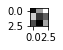

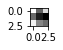

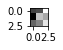

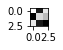

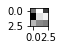

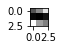

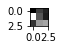

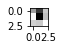

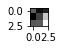

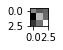

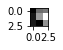

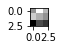

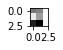

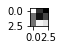

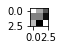

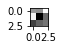

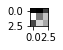

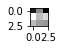

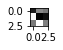

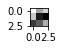

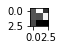

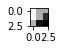

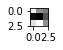

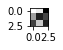

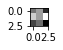

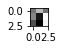

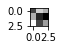

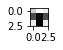

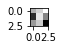

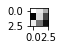

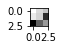

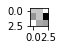

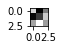

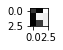

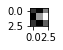

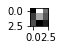

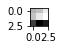

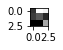

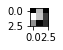

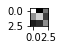

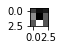

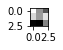

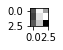

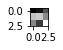

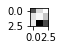

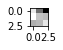

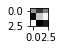

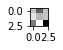

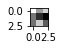

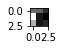

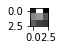

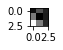

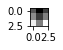

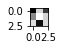

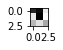

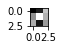

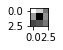

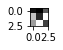

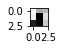

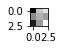

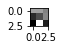

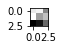

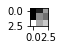

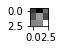

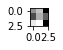

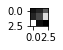

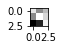

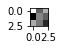

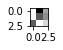

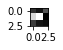

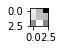

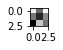

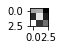

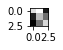

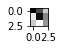

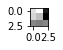

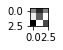

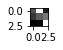

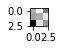

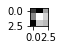

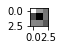

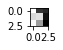

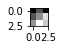

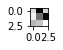

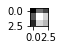

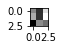

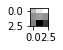

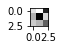

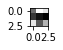

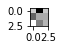

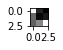

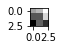

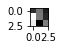

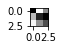

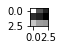

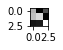

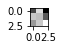

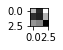

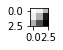

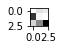

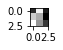

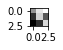

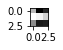

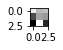

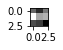

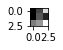

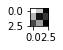

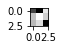

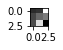

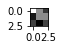

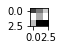

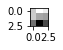

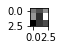

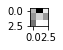

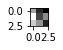

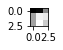

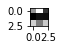

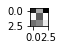

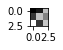

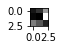

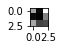

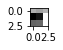

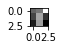

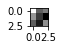

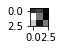

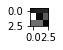

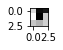

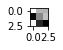

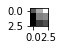

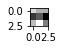

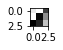

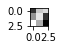

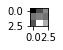

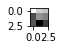

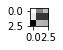

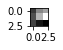

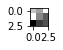

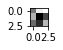

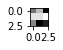

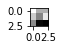

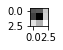

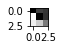

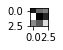

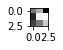

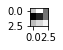

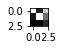

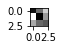

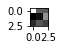

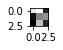

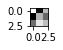

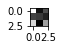

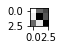

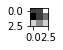

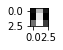

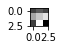

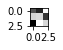

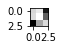

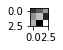

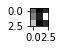

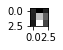

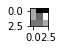

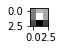

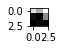

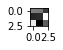

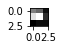

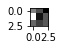

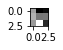

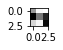

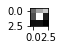

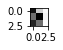

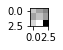

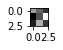

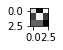

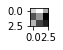

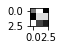

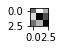

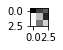

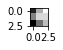

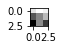

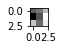

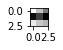

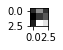

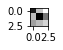

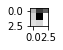

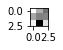

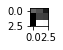

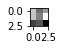

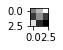

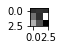

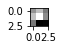

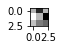

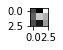

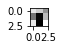

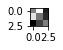

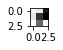

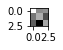

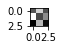

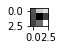

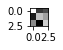

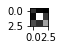

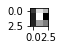

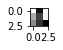

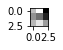

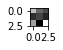

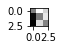

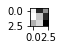

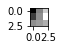

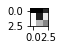

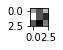

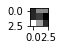

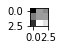

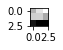

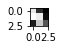

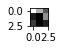

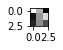

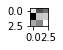

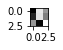

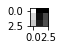

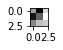

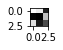

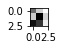

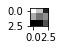

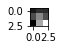

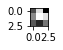

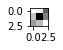

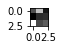

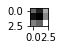

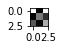

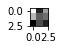

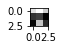

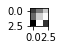

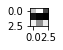

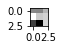

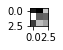

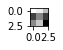

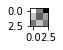

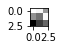

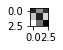

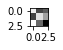

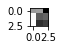

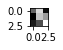

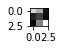

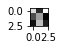

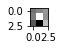

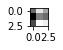

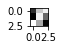

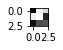

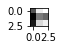

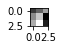

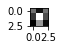

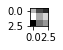

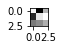

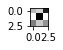

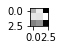

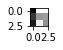

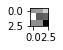

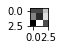

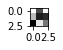

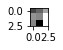

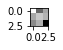

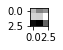

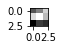

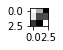

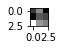

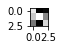

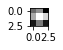

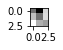

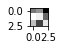

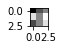

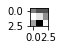

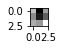

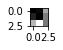

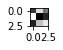

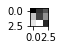

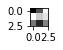

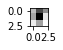

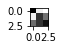

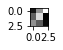

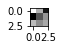

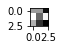

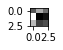

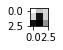

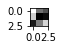

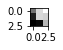

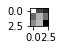

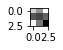

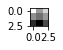

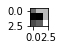

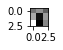

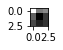

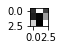

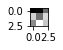

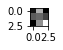

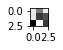

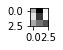

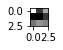

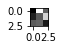

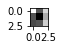

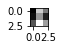

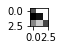

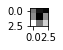

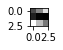

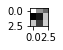

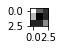

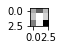

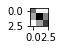

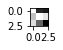

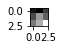

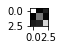

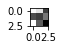

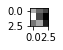

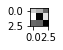

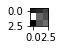

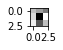

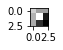

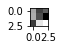

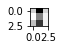

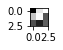

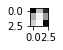

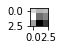

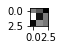

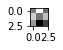

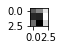

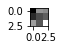

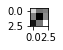

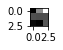

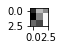

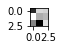

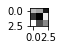

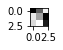

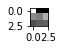

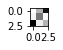

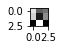

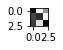

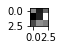

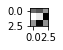

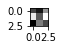

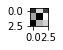

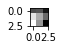

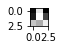

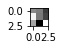

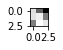

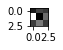

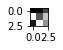

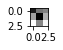

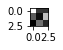

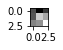

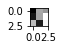

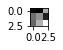

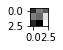

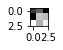

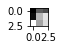

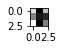

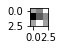

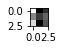

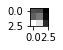

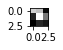

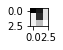

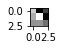

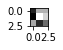

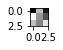

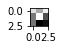

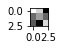

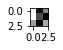

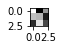

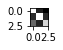

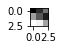

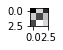

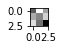

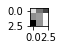

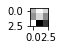

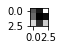

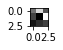

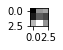

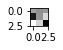

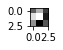

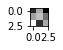

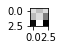

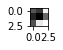

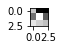

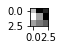

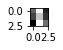

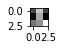

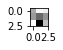

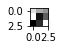

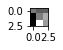

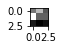

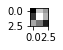

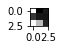

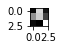

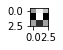

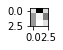

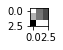

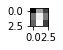

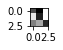

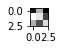

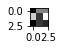

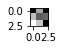

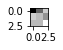

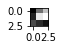

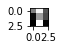

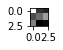

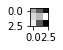

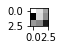

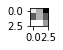

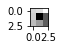

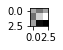

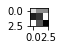

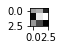

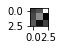

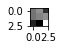

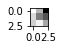

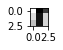

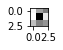

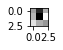

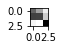

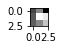

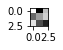

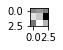

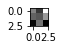

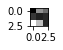

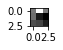

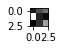

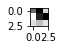

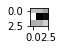

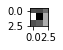

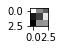

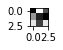

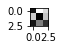

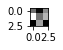

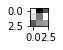

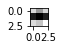

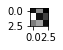

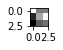

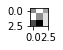

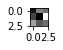

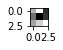

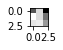

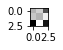

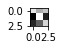

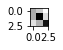

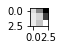

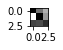

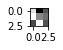

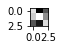

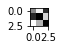

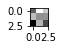

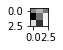

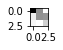

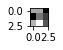

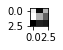

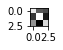

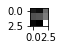

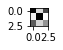

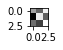

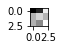

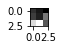

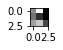

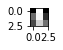

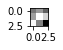

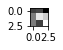

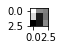

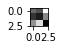

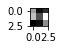

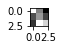

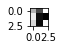

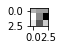

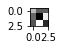

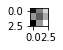

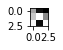

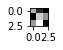

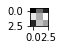

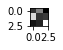

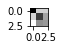

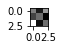

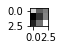

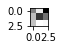

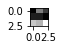

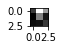

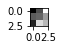

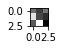

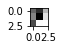

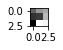

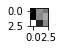

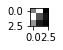

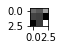

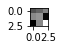

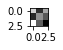

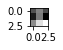

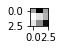

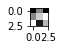

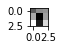

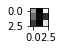

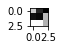

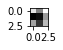

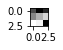

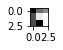

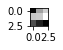

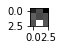

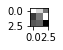

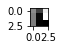

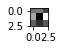

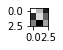

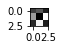

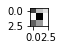

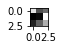

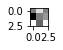

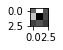

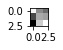

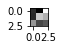

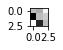

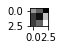

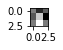

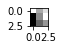

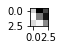

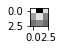

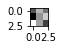

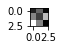

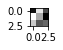

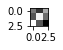

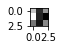

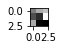

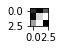

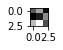

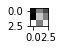

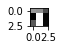

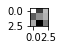

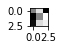

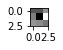

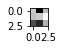

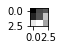

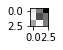

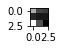

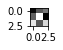

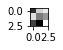

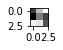

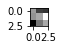

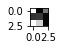

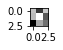

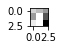

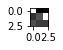

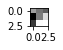

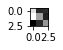

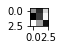

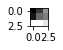

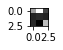

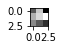

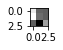

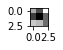

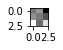

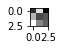

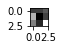

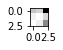

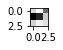

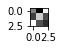

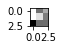

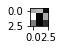

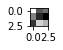

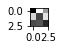

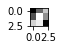

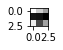

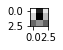

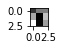

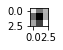

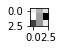

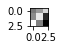

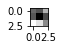

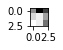

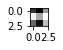

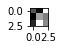

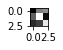

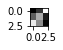

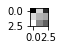

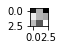

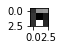

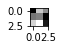

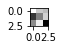

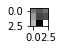

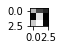

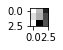

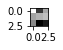

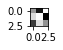

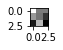

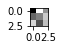

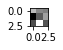

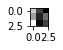

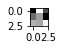

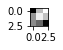

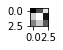

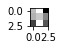

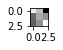

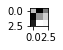

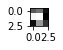

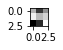

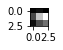

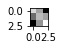

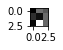

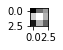

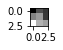

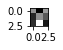

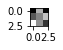

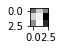

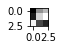

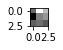

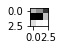

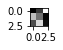

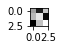

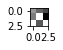

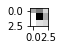

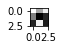

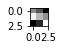

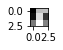

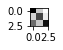

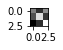

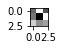

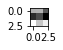

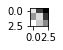

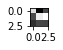

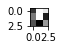

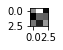

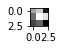

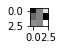

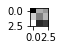

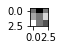

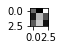

In [72]:
from matplotlib import pyplot as plt

filters = model.state_dict()['estimate_kernel.Vertical1.7.weight']
filters = filters.cpu().detach().numpy()
filters = np.transpose(filters, (2, 3, 1, 0))
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

#shape of filters (3, 3, 25, 25)
n_filters, ix = 25, 1
for i in range(n_filters):
    # get the filter
    f = filters[:,:,:,i]
    #f = f[:,:,:,0]

    # kernel shape 3x3x25 but to plot it converting into 25 3×3 filters
    for j in range(25):
        # specify subplot and turn of axis
        plt.figure(figsize=(10, 10))
        ax = plt.subplot(n_filters, 25, ix)
        #ax.set_xticks([])
        #ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:,:,j], cmap='gray')
        ix += 1
        # show the figure
plt.show()


In [115]:
test_resultDir_final = args.save_dir + '/test_result_final2'
if not os.path.exists(test_resultDir_final):
        os.makedirs(test_resultDir_final)

In [116]:
print("Test Start...")
test_psnr = test(model, test_dataset, test_resultDir_final, output_name='output.png')
test_log = "PSNR on test data: {}".format(test_psnr)
print(test_log)

log_dir = args.save_dir + '/logging'

if os.path.exists(log_dir + '/log_test2.txt'):
    logfile = open(log_dir + '/log_test2.txt', 'a')
else:
    logfile = open(log_dir + '/log_test2.txt', 'w')
        
logfile.write(test_log)
logfile.close()

Test Start...
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
(1, 25, 256, 320)
(256, 320, 25, 1)
PSNR on test data: 33.230865649459886
